In [1]:
f# Základné importy pre dokumentáciu / rýchle testy
import os
from pathlib import Path

import numpy as np
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# Projektové importy (ak notebook spúšťame v koreňovom priečinku projektu)
from agent import Agent
from models import get_model
from config import SEED


C:\Users\zyppi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\triton\windows_utils.py:404: UserWarning: Failed to find CUDA.
  warnings.warn("Failed to find CUDA.")


# 1. Úvod

V tomto projekte riešime **multitriednu klasifikáciu obrázkov zvierat** pomocou **PyTorch**.
Počas tréningu logujeme priebeh do **Weights & Biases (wandb)** a ukladáme **najlepší model** podľa validačného **F1**.

V projekte máme:
- tréning + validáciu (split **70/30**),
- metriky: **Accuracy, Precision, Recall, F1**,
- automatické ukladanie best modelu do súboru `best_model_<run.id>.pth`,
- možnosť spustiť **W&B Sweep** na ladenie hyperparametrov.



použité knižnice so far:
torch, torchvision, numpy, scikit-learn, wandb, matplotlib, pillow, imagehash


# 2. Analýza dát

Dataset načítavame cez `torchvision.datasets.ImageFolder`.

Príklad:

```
filtered-img-128/
  cat/
  dog/
  ...
```

V projekte máme pripravené viaceré verzie datasetu podľa rozlíšenia:
- `filtered-img-64`
- `filtered-img-128`
- `filtered-img-256`

Cestu datasetu vyberáme podľa `image_size`.


## 2.1 Načítanie datasetu + zistenie tried

V tejto bunke:
- nastavíme `IMAGE_SIZE` (rovnako ako pri tréningu),
- skontrolujeme, či existuje príslušný priečinok,
- načítame `ImageFolder`,
- vypíšeme triedy a počty obrázkov.


In [2]:
# Zmeňme podľa toho, s čím trénujeme
# test.py má default: IMAGE_SIZE = 128
IMAGE_SIZE = 128

root_map = {
    64:  Path("./filtered-img-64"),
    128: Path("./filtered-img-128"),
    224: Path("./filtered-img-224"),
    256: Path("./filtered-img-256"),
}
root = root_map.get(IMAGE_SIZE, Path(f"./filtered-img-{IMAGE_SIZE}"))

if not root.exists():
    print(f"❌ Dataset priečinok neexistuje: {root.resolve()}")
    print("➡️ Skontrolujme, že máme vytvorený filtered-img-64 / 128 / 256 podľa IMAGE_SIZE.")
else:
    ds = datasets.ImageFolder(str(root))
    print("✅ Dataset načítaný:", root)
    print("Počet tried:", len(ds.classes))
    print("Triedy:", ds.classes)

    counts = {cls: 0 for cls in ds.classes}
    for _, y in ds.samples:
        counts[ds.classes[y]] += 1

    print("\nPočty obrázkov na triedu:")
    for k, v in counts.items():
        print(f"{k:25s} {v}")

    print("\nPočet obrázkov celkovo:", len(ds))


✅ Dataset načítaný: filtered-img-128
Počet tried: 10
Triedy: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

Počty obrázkov na triedu:
butterfly                 2038
cat                       1627
chicken                   2845
cow                       1691
dog                       4760
elephant                  1361
horse                     2458
sheep                     1600
spider                    4662
squirrel                  1748

Počet obrázkov celkovo: 24790


## 2.2 Zastúpenie tried (graf)

Graf nám pomôže rýchlo vidieť, či je dataset vyvážený alebo nie.


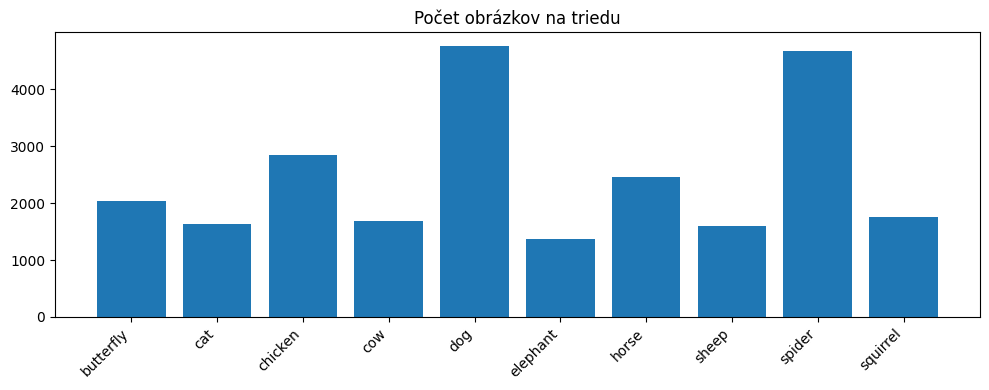

In [4]:
if 'ds' in globals():
    counts = {cls: 0 for cls in ds.classes}
    for _, y in ds.samples:
        counts[ds.classes[y]] += 1

    labels = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(10,4))
    plt.bar(labels, values)
    plt.xticks(rotation=45, ha='right')
    plt.title("Počet obrázkov na triedu")
    plt.tight_layout()
    plt.show()


## 2.3 Ukážky obrázkov

Tu si rýchlo overíme:
- že obrázky sa načítavajú správne,
- že labely (názvy tried) sedia,
- že dataset nie je pomiešaný.


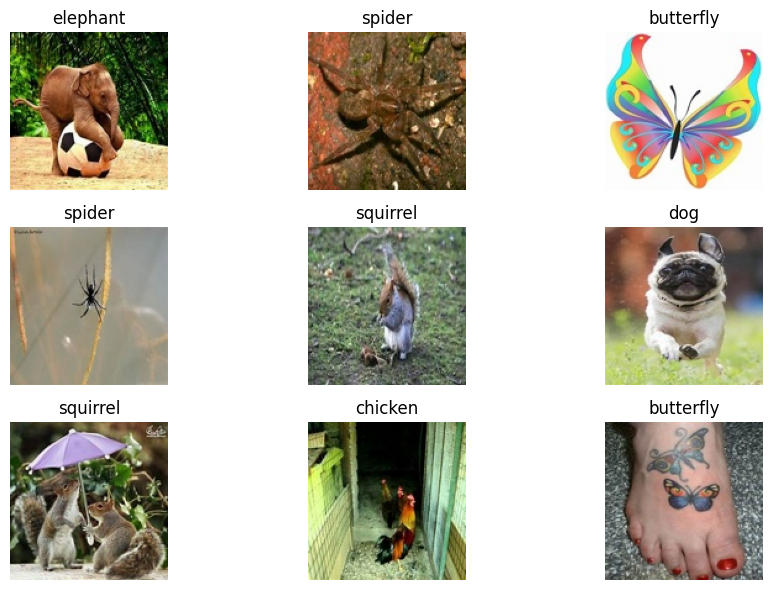

In [5]:
from PIL import Image
import random

if 'ds' in globals():
    plt.figure(figsize=(10,6))
    for i in range(9):
        idx = random.randint(0, len(ds)-1)
        path, y = ds.samples[idx]
        img = Image.open(path).convert("RGB")

        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(ds.classes[y])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# 3. Metodológia

### 3.1 Transformácie (augmentácia)
Tréning: flipy, rotácia, ColorJitter, ToTensor.  
Validácia: iba ToTensor.

### 3.2 Rozdelenie dát
Používame split: 70% train / 30% val a seed `SEED` (v `config.py`) pre reprodukovateľnosť.

### 3.3 Vyváženie tried
Počítame váhy tried z počtov obrázkov a používame ich v:
`CrossEntropyLoss(weight=class_weights)`.

### 3.4 Modely
Modely sú v `models.py`:
- `small`, `jack`, `deep`, `wide`, `our-resnet`

Pozn.: architektúra je postavená ako CNN extraktor + **Spatial RNN head (GRU/LSTM)** nad priestorovou sekvenciou feature mapy.

### 3.5 Optimalizácia
Optimizer: Adam (alebo RMSprop), Scheduler: ReduceLROnPlateau.


## 3.6 Metriky (Precision / Recall / F1)

- **Precision**: \(\frac{TP}{TP+FP}\)  
- **Recall**: \(\frac{TP}{TP+FN}\)  
- **F1**: \(2\cdot\frac{PR}{P+R}\)

Best model ukladáme podľa validačného **F1**.


# 4. Výsledky experimentov

Vo W&B sledujeme:
- `train_loss`, `val_loss`
- `train_acc`, `val_acc`
- `precision`, `recall`, `f1`

Link na W&B sweep report:
- *[(sweep report)](https://wandb.ai/zyppi-stu/ZNEUS_pr_2_MiklovicKekelak/reports/10-Animal-classification--VmlldzoxNTI5NjM2OQ?accessToken=za2a1l9qeil9b9x1f9qswnjh6h111h4zrtg2xl5oxo9klyxs4lizk8trlydv4j51)*


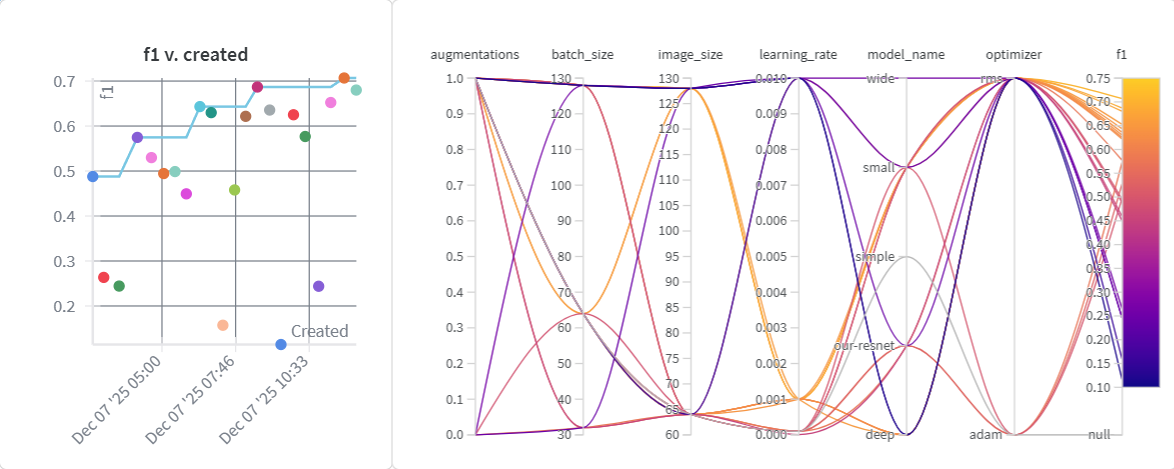
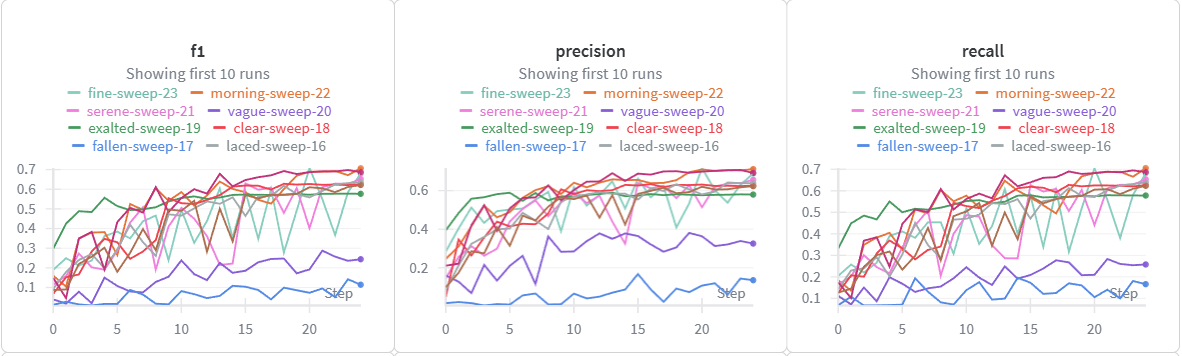
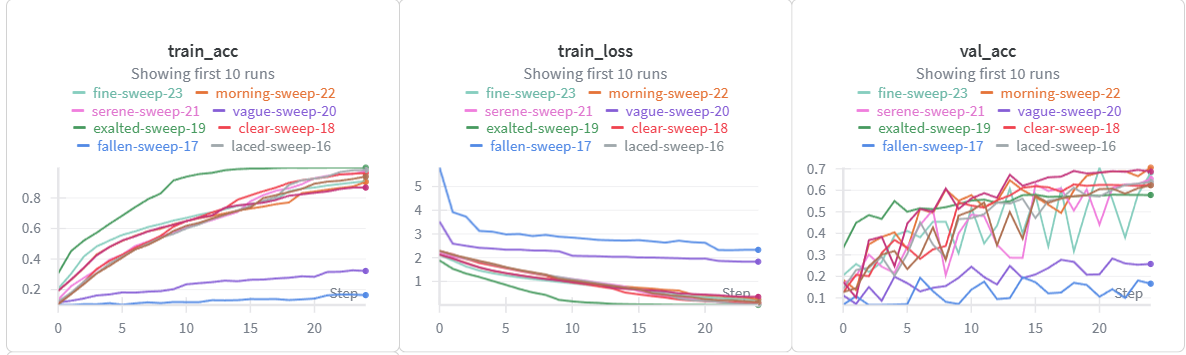
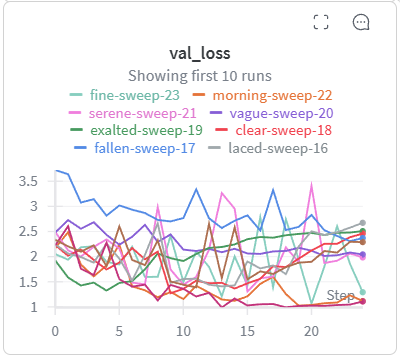


## 4.1 Spustenie jedného tréningu (`test.py`)

Aktuálne nastavenie v `test.py` (single_run_test) je:
- `model_name="small"`
- `lr=1e-3`
- `batch_size=128`
- `epochs=50`
- `image_size=128`

Spustenie v termináli:

```bat
wandb login
python test.py
```


## 4.2 Kde sa ukladá najlepší model

V `agent.py` ukladáme best model do súboru s run id:

```python
model_filename = f"best_model_{run.id}.pth"
torch.save(self.model.state_dict(), model_filename)
```

Súbor sa uloží do priečinka, z ktorého spúšťame tréning (aktuálny working directory).


## 4.3 Ako otestovať uložený best model

Nižšie:
- vytvoríme `Agent` s rovnakým configom,
- načítame `best_model_<runid>.pth`,
- vyhodnotíme cez `Agent.evaluate()`.

`run.id` (v názve run-u alebo v URL).


In [10]:
from types import SimpleNamespace

config = SimpleNamespace(
    model_name="small",
    lr=1e-3,
    batch_size=128,
    epochs=1,
    image_size=128,
    seed=SEED,
)

agent = Agent(config)

best_path = Path("best_model_6gyii9ra.pth")

if not best_path.exists():
    print("❌ Súbor best modelu sa nenašiel:", best_path)
    print("➡️ Skontrolujme názov súboru alebo spustime tréning cez `python test.py` v tomto priečinku.")
else:
    agent.model.load_state_dict(torch.load(best_path, map_location=agent.device))
    agent.model.eval()
    val_loss, val_acc, precision, recall, f1 = agent.evaluate()

    print("✅ Vyhodnotenie best modelu")
    print("val_loss  :", val_loss)
    print("val_acc   :", val_acc)
    print("precision :", precision)
    print("recall    :", recall)
    print("f1        :", f1)


 Using CUDA/GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   CUDA Version: 12.6
   GPU Memory: 8.00 GB
✅ Vyhodnotenie best modelu
val_loss  : 1.1159685728913646
val_acc   : 0.7059298104074223
precision : 0.7114822723005796
recall    : 0.7059298104074223
f1        : 0.7068210097755061


## 4.4 Predikcia jedného obrázka (inferencia)

Ukážka, predikcie pre jeden obrázok:
- predikovanú triedu,
- confidence (pravdepodobnosť).



In [20]:
from PIL import Image
from torchvision import datasets, transforms

MODEL_NAME = "small"
IMAGE_SIZE = 128

root_map = {64:"./filtered-img-64", 128:"./filtered-img-128", 224:"./filtered-img-224", 256:"./filtered-img-256"}
root = root_map[IMAGE_SIZE]
ds = datasets.ImageFolder(root)
class_names = ds.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(MODEL_NAME, num_classes=len(class_names)).to(device)
best_path = Path("best_model_6gyii9ra.pth") # ID modelu
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

img_path = "filtered-img-128\cat\cat_00080.jpg"  # obrazok
img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax().item())

print("Predikcia:", class_names[pred_idx])
print("Confidence:", float(probs[pred_idx]))


Predikcia: cat
Confidence: 0.6162093281745911


## 4.5 W&B Sweep

V projekte máme aj `run_sweep.py` + `sweep.yaml`.
Typický postup:

```bat
wandb sweep .\sweep.yaml
wandb agent ENTITY/PROJECT/SWEEP_ID
```



## 6. Zhrnutie našej práce

- Dataset načítavame cez ImageFolder a pripravujeme split 70/30.
- Tréning pipeline máme v PyTorch a používame augmentácie.
- Logujeme do W&B: loss, acc, precision/recall/f1.
- Best model ukladáme podľa validačného F1 (`best_model_<run.id>.pth`).
- Sweepy používame na automatické ladenie hyperparametrov.
